# Imports

In [80]:
from typing import TypedDict, Optional, Dict,Annotated ,List
from langgraph.graph import StateGraph ,START,END
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langgraph.graph.message import  add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import  MessagesState
from langchain_core.messages import HumanMessage,SystemMessage ,AnyMessage, AIMessage
from pydantic import  BaseModel,Field
from Prompts import  Prompts

# Utilities

In [51]:
def pretty_print(messages):
    print("===Pritning state , hold tight=======") 
    print(state)
    print("===The loop isn't looping please wait===") 
    for msg in messages:
        print("=======")
        print(msg)
        print("=======")

# LLM

In [52]:
API_KEY="LNDn2rbGUIGZznn1NXT7U4VcADf-d"
ENDPOINT="https://cloud.olakrutrim.com/v1"
MODEL_NAME="Llama-3.3-70B-Instruct"

llm = ChatOpenAI(api_key=API_KEY, base_url=ENDPOINT, model=MODEL_NAME)


Buisness need 
Gather and Analyze business requirments 
Deffine scope and Granularity 
Identify Fact Tables and Their Measures 
Define Dimensions and Conformed Dimensions
Design the Star Schema Structure
Optimize for Performance and Scalability
Validate, Test, and Document

# Pydantic Models

In [66]:
class BuisnessNeedPreProcessed(BaseModel):    
    messages:Optional[Annotated[List[AnyMessage], add_messages, Field(description="Conversations as stored")]]=None
    processed_technical_conversions:Optional[Annotated[List[str],Field(description="")]]=None

In [67]:
class GranularityScope(BaseModel):
    conversions:Annotated[str, Field(description="Conversations as stored")]

In [68]:
class SchemaDesign(BaseModel):
    conversions:Annotated[str, Field(description="Conversations as stored")]

In [69]:
class PerformanceOptimization(BaseModel):
    pass

In [70]:
class ErDiagram(BaseModel):
    pass

# Codd State

In [71]:
class CoddState(BaseModel):
    business_need: Optional[Annotated[BuisnessNeedPreProcessed, Field(description="Original raw business need text as provided by the client")]] =None

# Nodes of graph

In [72]:
def conversation_node(state: CoddState):
    print("Hello Brother")
    i = 1
    while i != 0:
        print(state.business_need.messages)
        response = llm.invoke(state.business_need.messages)
        print(response)
        i = i - 1
        
    return {
        "business_need":{ 
            "messages": state.business_need.messages
        }   
    }

# Edges of Graph

In [81]:
def routing_function(state:CoddState):
    if state.business_need and state.business_need.messages:
        last_message=state.business_need.messages[-1]
        if last_message is AIMessage:
            # suppose  last message is a string
            if last_message.content.contains("EXIT"):
                return True
    
    return False

# Config Thread

In [82]:
config = {"configurable": {"thread_id": "abc123"}}

In [83]:

config_234 = {"configurable": {"thread_id": "abc234"}}

# Graph of the workflow

In [84]:
workflow = StateGraph(state_schema=CoddState)
workflow.add_edge(START, "coversation_node")
workflow.add_node("conversation_node", conversation_node)
workflow.add_conditional_edges("conversation_node", routing_function, {True: "next_node", False: "conversation_node"})
workflow.add_node("next_nodee",END)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

# Complie the Workflow with memory

In [76]:
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Display the graph

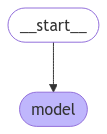

In [77]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

# Test and Run it 

### Run on same thread

### Run on sperate Thread

In [79]:
input_messages = [SystemMessage(Prompts.gen_analysis_business_need()), HumanMessage("What about the business needs ")]
try:
    output = app.invoke({"business_need": {"messages":input_messages}}, config_234)
except Exception as err:
    print(err)

Hello Brother
[SystemMessage(content='\n                    You are Codd, a knowledgeable and playful chatbot specialized in Database Administration and Data Modeling. Your mission is to help users refine their business needs for designing an OLAP data store by engaging in a friendly, clear, and jargon-free conversation. Your responses should feel warm and human, not robotic. Follow these guidelines:\n\n                    1. **Listen Carefully:** When a business need is provided, read it thoroughly.\n                    2. **Analyze & Inquire:** Break down the business need into its key components and ask simple, thoughtful questions to gather more details. For example:\n                    - "Could you explain what you mean by \'sales trends\'? Are you looking for daily, weekly, or monthly patterns?"\n                    - "Which product categories do you want to focus on?"\n                    - "How do you define a loyal customer for your business?"\n                    3. **Keep I

# Experiments 

In [71]:

from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory()
conversation = ConversationChain(llm=llm, memory=memory)

initial_prompt = (
    "We need to build a data warehouse that integrates data from our ERP and CRM systems "
    "to improve reporting and decision-making. Ask me any questions to clarify our requirements. "
    "When you have all the information you need, simply reply with 'STOP'."
)

response = conversation.run(initial_prompt)
print("LLM:", response)

while True:
    # Ask the next question or prompt
    next_output = conversation.run("Next question?")
    print("LLM:", next_output)
    
    # Check if the LLM signals that it is done
    if "STOP" in next_output.upper():
        print("LLM decided to stop asking questions.")
        break

    # (Optional) Simulate user responses here. In a real application, you might capture user input.
    user_input = input("Your answer: ")
    conversation.run(user_input)


/tmp/ipykernel_5501/2196735241.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()


NameError: name 'ConversationChain' is not defined